In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt


In [12]:

stock_symbol = "AAPL"
df = yf.download(stock_symbol, start="2024-01-01", end="2025-01-01")

df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.734970,187.521323,182.993502,186.237603,82488700
2024-01-03,183.351746,184.973804,182.535736,183.321893,58414500
2024-01-04,181.023178,182.197418,179.998201,181.261998,71983600
2024-01-05,180.296692,181.868991,179.291621,181.102756,62303300
2024-01-08,184.655365,184.695178,180.615161,181.202281,59144500


In [5]:

scaler = MinMaxScaler(feature_range=(0,1))
data = df[['Close']].values
data_scaled = scaler.fit_transform(data)


def create_sequences(data, time_steps=60):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        Y.append(data[i+time_steps])
    return np.array(X), np.array(Y)


time_steps = 60
split = int(0.8 * len(data_scaled))
X_train, Y_train = create_sequences(data_scaled[:split], time_steps)
X_test, Y_test = create_sequences(data_scaled[split:], time_steps)

print(f"Training Samples: {X_train.shape}, Testing Samples: {X_test.shape}")


Training Samples: (1751, 60, 1), Testing Samples: (393, 60, 1)


In [6]:
def build_model(hp):
    model = Sequential([
        LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16),
             return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=16), return_sequences=False),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model, objective='val_loss', max_trials=5, executions_per_trial=1,
    directory='tuner_results', project_name='stock_price_tuning'
)


tuner.search(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))


best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)


best_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))


Trial 5 Complete [00h 01m 27s]
val_loss: 0.0008128217305056751

Best val_loss So Far: 0.0006387306493707001
Total elapsed time: 00h 11m 56s
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0237 - val_loss: 0.0012
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 7.2574e-04 - val_loss: 0.0016
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 6.5704e-04 - val_loss: 0.0013
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 6.1103e-04 - val_loss: 0.0011
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 5.2905e-04 - val_loss: 9.0495e-04
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 4.5887e-04 - val_loss: 0.0013
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 4.5303e-04 - val_loss: 0.0011
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 4.6942e-04 - val_loss: 9.3637e-04
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 6.1780e-04 - val_loss: 7.8379e-04
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 95

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


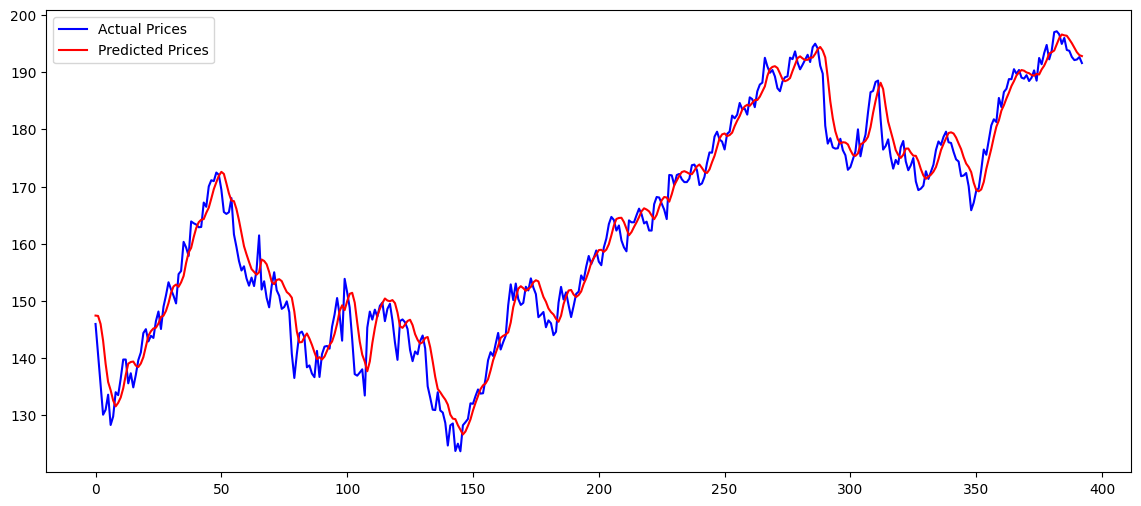

In [7]:

predictions = best_model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(14,6))
plt.plot(Y_test_actual, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/s

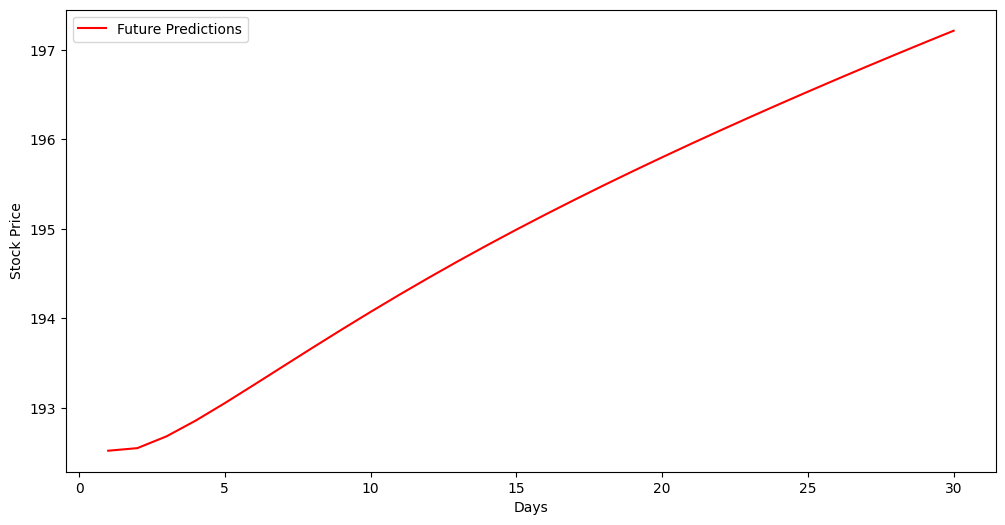

In [8]:
last_60_days = data_scaled[-60:]
future_input = last_60_days.reshape(1, -1, 1)

future_predictions = []

for _ in range(30):
    predicted_price = best_model.predict(future_input)
    future_predictions.append(predicted_price[0][0])
    future_input = np.append(future_input[:, 1:, :], [[[predicted_price[0][0]]]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(range(1, 31), future_predictions, label="Future Predictions", color='red')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [9]:
signals = []
for i in range(1, len(future_predictions)):
    if future_predictions[i] > future_predictions[i-1]:
        signals.append("BUY")
    else:
        signals.append("SELL")

days = np.arange(1, len(future_predictions) + 1)
signals_df = pd.DataFrame({"Day": days[1:], "Predicted Price": future_predictions[1:].flatten(), "Signal": signals})

print(signals_df.head())


   Day  Predicted Price Signal
0    2       192.549911    BUY
1    3       192.681549    BUY
2    4       192.857300    BUY
3    5       193.052841    BUY
4    6       193.256958    BUY


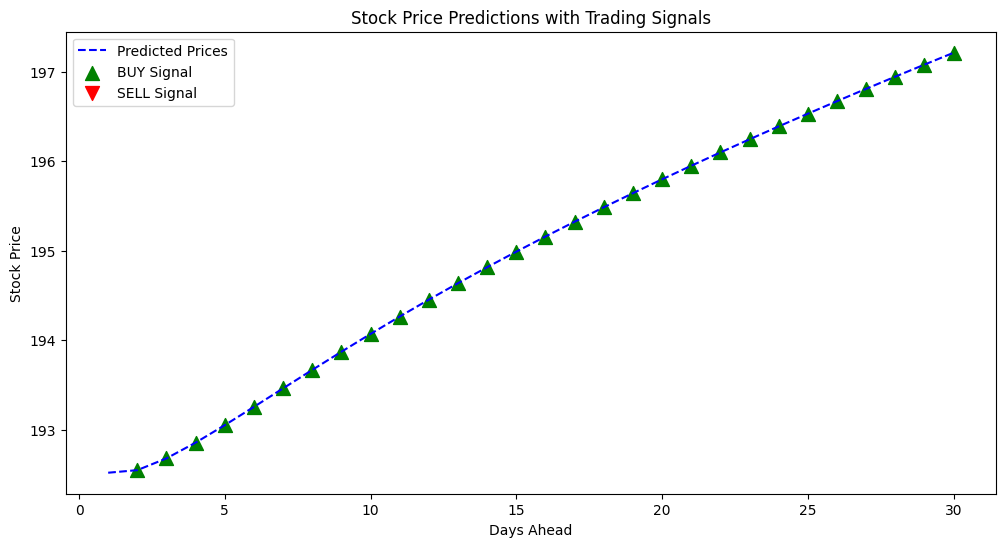

In [10]:
plt.figure(figsize=(12,6))
plt.plot(days, future_predictions, label="Predicted Prices", color='blue', linestyle="dashed")

buy_days = signals_df[signals_df["Signal"] == "BUY"]["Day"]
buy_prices = signals_df[signals_df["Signal"] == "BUY"]["Predicted Price"]
plt.scatter(buy_days, buy_prices, marker="^", color="green", label="BUY Signal", s=100)

sell_days = signals_df[signals_df["Signal"] == "SELL"]["Day"]
sell_prices = signals_df[signals_df["Signal"] == "SELL"]["Predicted Price"]
plt.scatter(sell_days, sell_prices, marker="v", color="red", label="SELL Signal", s=100)

plt.xlabel("Days Ahead")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Predictions with Trading Signals")
plt.show()
